In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import inv
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython import display

# Advection Diffusion Equation
Consider the concentration of a material in a 1D space where the concentration at point $x$ and time $t$ is given by $u(x, t)$. The advection diffusion equation describing the change in concentration over time is given by

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} - v \frac{\partial u}{\partial x}$$

where at first we consider the source term $s(x, t) = 0, \forall x, t$.

First, let's apply a <i>Forward Finite Difference Scheme</i> to the time derivative 

$$\frac{\partial u}{\partial t} = \frac{u_j^{t+1}-u_j^{t}}{\Delta t}$$

Next, apply a <i>Crank-Nicolson Finite Difference Scheme</i> to the <b>diffusion</b> term

$$D \frac{\partial^2 u}{\partial x^2} = \frac{D}{2 \Delta x^2} ((u_{j+1}^{t+1} - 2u_{j}^{t+1} + u_{j-1}^{t+1})+(u_{j+1}^{t} - 2u_{j}^{t} + u_{j-1}^{t})$$

Lastly, let's apply an <i>Order 4 Central Finite Difference Scheme</i> to the <b>advection</b> term

$$v \frac{\partial u}{\partial x} = \frac{-u_{j+2}^t+8u_{j+1}^t-8u_{j-1}^t+u_{j-2}^t}{12}$$

Putting all of this together we get the following equation

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} - v \frac{\partial u}{\partial x} \\ \frac{u_j^{t+1}-u_j^{t}}{\Delta t} = \frac{D}{2 \Delta x^2} ((u_{j+1}^{t+1} - 2u_{j}^{t+1} + u_{j-1}^{t+1})+(u_{j+1}^{t} - 2u_{j}^{t} + u_{j-1}^{t}) - \frac{v}{12}(-u_{j+2}^t+8u_{j+1}^t-8u_{j-1}^t+u_{j-2}^t)$$

Which simplifies to the following when we move all $u^{t+1}$ terms to the left

$$\frac{-D \Delta t}{2 \Delta x^2}(u_{j+1}^{t+1} + u_{j-1}^{t+1}) + (1 + \frac{\Delta t D}{\Delta x^2}) u_j^{t+1}$$

And which simplifies to the following when we move all $u^t$ terms to the right.

$$-u_{j+2}^t\left(- \frac{v \Delta t}{12}\right) + u_{j+1}^t\left(\frac{D \Delta t}{2 \Delta x^2} + \frac{8v \Delta t}{12}\right) - u_j^t (\frac{D \Delta t}{\Delta x^2}) + u_{j-1}^t (\frac{D \Delta t}{2 \Delta x^2} - \frac{8v \Delta t}{12}) + u_{j-2}^{t}(\frac{v \Delta t}{12})$$

We can describe this equation with the following matrix equation

$$B \boldsymbol{u_{t+1}} = C \boldsymbol{u_t}$$

Where $\boldsymbol{u_{t+1}} = [u_0^{t+1}, \dots, u_i^{t+1}, \dots, u_n^{t+1}]$ and $\boldsymbol{u_{t}} = [u_0^{t}, \dots, u_i^{t}, \dots, u_n^{t}]$.

Finally, I'm all out of LaTEX energy, but the diaganols of the $B$ and $C$ matrices correspond to the coefficient in front of each $u$ term.

In [2]:
# Define the spatial domain
x_start = -1
x_end = 1
x = x_end - x_start
Nx = 1000
dx = x / Nx

# Define the temporal domain
# max_dt = max_stable_timestep(dx, D)
# print(max_dt)
dt = 1e-3
time_bounds = [0, 0.5]
Nt = int((time_bounds[1] - time_bounds[0]) / dt)
print(f'{Nt} time steps')

# Define model parameters
theta = 0.5
D = 0
v = 100

# Create system of linear equations from the model parameters
b0 = 1 + ((2 * theta * D * dt)/dx**2)
b_ = (-theta * D * dt) / dx**2
B = sparse.diags([b_, b0, b_], [-1, 0, 1], shape=[Nx, Nx])

c0 = 1 - (2*(1-theta)*D*dt)/dx**2
c_ = ((2*(1-theta)*D*dt)/dx**2) - (8*v*dt/12)
c__ = v*dt/12
c_1 = ((8*v*dt)/12) + (((1-theta)*D*dt)/dx**2)
c_2 = -v*dt/12
C = sparse.diags([c__, c_, c0, c_1, c_2], [-2, -1, 0, 1, 2], shape=[Nx, Nx])

# Define initial conditions and boundary conditions
u = np.zeros([Nx, Nt])
u[100:200, 0] = 1
print(b0, b_)
print(c0, c_, c__, c_1, c_2)

500 time steps
1.0 -0.0
1.0 -0.06666666666666667 0.008333333333333333 0.06666666666666667 -0.008333333333333333


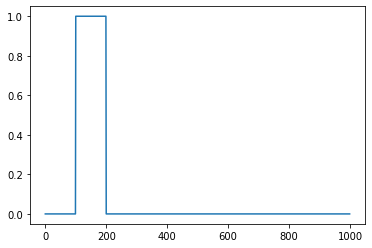

In [3]:
plt.plot(u[:, 0])
plt.show()

In [4]:
time_elapsed = time_bounds[0]
B_inv = inv(B)
BC = B_inv @ C

for i in range(Nt-1):
    # Do a forward time step
    u[:, i+1] = BC @ u[:, i]

    # Enforce the boundary conditions
    u[0, i+1] = 0.
    u[-1, i+1] = 0.

/Users/anthony/CompSci/UMontana/2021_Fall/CS592-PDEs/venv/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/Users/anthony/CompSci/UMontana/2021_Fall/CS592-PDEs/venv/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


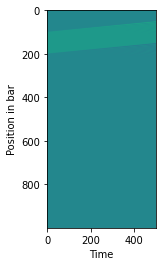

In [5]:
plt.imshow(u[:, :])
plt.xlabel('Time')
plt.ylabel('Position in bar')
plt.show()

In [6]:
fig, ax = plt.subplots(figsize=(10, 8.5))
line, = ax.plot(range(Nx), u[:, 0])
ax.set_ylim([-0.01, 1.1])

def animate(i):
    line.set_ydata(u[:, i])
    return line,
    
frames = u.shape[1] - 1
anim = FuncAnimation(fig, animate, interval=10, frames=frames, repeat=False, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())  